In [1]:
%load_ext autoreload
%autoreload 2
import sys
# do this to be able to import the custom python scripts
sys.path.insert(1, "../../../python_scripts")
import os

import recordlinkage as rl
from recordlinkage import preprocessing
from recordlinkage.datasets import load_febrl1, load_febrl2, load_febrl3, load_febrl4

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import dm_diagnostics as dmd
import dm_utils
import dm_file_checker

from itertools import combinations

import json

import dedupe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import simplejson

RANDOM_SEED = 1001

## Get Appropriate Filepaths

In [2]:
saved_files_path = "../../../saved_files"
task_name = os.path.basename(os.getcwd())
    
# files to be read in
is_data_source_deduped = dm_file_checker.check_is_data_source_deduped(task_name, saved_files_path)
settings_filepath =  dm_file_checker.get_filepath(task_name, "model_settings", saved_files_path)
labeled_pair_ids_filepath = dm_file_checker.get_filepath(task_name, "labeled_pair_ids", saved_files_path)

# folders to be written out as output
settings_filepath =  dm_file_checker.get_filepath(task_name, "model_settings_test_split", saved_files_path)
labeled_data_filepath = dm_file_checker.get_filepath(task_name, "labeled_data_test_split", saved_files_path)
RECALL_TRAIN_VAL = dm_file_checker.get_task_info(task_name, "recall_train", saved_files_path)
print("Using recall value of {}".format(RECALL_TRAIN_VAL))

Using recall value of 1.0


## Define parameters for model

In [3]:
# default blocked_proportion is 50%
BLOCKED_PROPORTION = 0.5
# default sample size is 15000
#SAMPLE_SIZE = 30_000
SAMPLE_SIZE = 15_000

## Setup: Reading in Unlabeled Data

In [4]:
if is_data_source_deduped:
    unlabeled_data_1, unlabeled_data_2 = dm_utils.get_deduped_data_for_rl(task_name, saved_files_path)
    print("Using canonicalized deduped dataset instead of the original preprocessed data.")
else:
    unlabeled_data_1_filepath, unlabeled_data_2_filepath = dm_file_checker.get_proper_unlabeled_data_filepath(task_name, saved_files_path)
    print("Not using the canonicalized deduped dataset. Using the original preprocessed data.")
    
    numeric_fields_1, numeric_fields_2 = dm_file_checker.get_dataset_info(task_name, "numeric_fields", saved_files_path)
    print("Numeric fields 1 are {}".format(numeric_fields_1))
    print("Numeric fields 2 are {}".format(numeric_fields_2))
    
    unlabeled_data_1 = dm_utils.read_unlabeled_data_json(unlabeled_data_1_filepath, numeric_fields = numeric_fields_1)
    unlabeled_data_2 = dm_utils.read_unlabeled_data_json(unlabeled_data_2_filepath, numeric_fields = numeric_fields_2)

Not using the canonicalized deduped dataset. Using the original preprocessed data.
Numeric fields 1 are []
Numeric fields 2 are []
converting 94 empty string values of column date_of_birth to None
converting 112 empty string values of column given_name to None
converting 48 empty string values of column surname to None
converting 158 empty string values of column street_number to None
converting 98 empty string values of column address_1 to None
converting 420 empty string values of column address_2 to None
converting 55 empty string values of column suburb to None
converting 0 empty string values of column postcode to None
converting 50 empty string values of column state to None
converting 0 empty string values of column soc_sec_id to None
converting 263 empty string values of column date_of_birth to None
converting 234 empty string values of column given_name to None
converting 102 empty string values of column surname to None
converting 287 empty string values of column street_numb

## Train Test Split of Labeled Data

In [5]:
labeled_pair_ids_df = pd.read_csv(labeled_pair_ids_filepath, dtype = str)
labeled_pair_ids_df.head()

,record id 1,record id 2,label
0,febrl4a-rec-4751-org,febrl4b-rec-1657-dup-0,distinct
1,febrl4a-rec-2727-org,febrl4b-rec-3637-dup-0,distinct
2,febrl4a-rec-1221-org,febrl4b-rec-4758-dup-0,distinct
3,febrl4a-rec-11-org,febrl4b-rec-3489-dup-0,distinct
4,febrl4a-rec-4607-org,febrl4b-rec-375-dup-0,distinct


In [6]:
#sampling based on random split (may not be advisable because of active learning's sampling methodology)
labeled_pair_ids_train, labeled_pair_ids_test = train_test_split(labeled_pair_ids_df,
                                                                 test_size = 0.2,  
                                                                 random_state = RANDOM_SEED)
labeled_pair_ids_train = labeled_pair_ids_train.copy()
labeled_pair_ids_test = labeled_pair_ids_test.copy()
print(labeled_pair_ids_train.shape, labeled_pair_ids_test.shape)

(111, 3) (28, 3)


In [7]:
dm_utils.write_training_set_from_pairs(labeled_pair_ids_train, labeled_data_filepath, unlabeled_data_1, unlabeled_data_2)

## Retraining Model

In [8]:

fields = dm_file_checker.get_task_info(task_name, "fields", saved_files_path)
print("Using the following fields for the model")
print(fields)

linker = dedupe.RecordLink(fields, num_cores = 4)


Using the following fields for the model
[{'field': 'street_number', 'type': 'ShortString', 'has missing': True}, {'field': 'postcode', 'type': 'ShortString'}, {'field': 'state', 'type': 'ShortString', 'has missing': True}, {'field': 'soc_sec_id', 'type': 'ShortString'}, {'field': 'given_name', 'type': 'String', 'has missing': True}, {'field': 'surname', 'type': 'String', 'has missing': True}, {'field': 'address_1', 'type': 'String', 'has missing': True}, {'field': 'address_2', 'type': 'String', 'has missing': True}, {'field': 'suburb', 'type': 'String', 'has missing': True}, {'field': 'date_of_birth', 'type': 'DateTime', 'has missing': True, 'fuzzy': False, 'yearfirst': True}]


In [9]:
%%time
dm_utils.prepare_training_linker(linker, unlabeled_data_1, unlabeled_data_2,
                                 labeled_data_filepath, 
                                  blocked_proportion = BLOCKED_PROPORTION, 
                                  sample_size = SAMPLE_SIZE)

INFO:dedupe.api:reading training from file


reading labeled examples from  ../../../saved_files/rl-febrl4a_febrl4b/test_split_output/labeled_data.json


INFO:dedupe.canopy_index:Removing stop word  s
INFO:dedupe.canopy_index:Removing stop word et
INFO:dedupe.canopy_index:Removing stop word re
INFO:dedupe.canopy_index:Removing stop word st
INFO:dedupe.canopy_index:Removing stop word ce
INFO:dedupe.canopy_index:Removing stop word ee
INFO:dedupe.canopy_index:Removing stop word tr
INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(SimplePredicate: (commonTwoTokens, address_2), TfidfNGramSearchPredicate: (0.8, address_1))
INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(LevenshteinSearchPredicate: (2, postcode), LevenshteinSearchPredicate: (2, soc_sec_id))
INFO:dedupe.training:(SimplePredicate: (wholeFieldPredicate, date_of_birth), TfidfTextSearchPredicate: (0.2, address_1))
INFO:dedupe.training:(SimplePredicate: (commonThreeTokens, suburb), TfidfNGramSearchPredicate: (0.4, postcode))
INFO:dedupe.training:(LevenshteinSearchPredicate: (3, surname), SimplePredicate: (commonFourGram, street_number))
INFO:dedupe.trai

CPU times: user 6min 45s, sys: 2.81 s, total: 6min 48s
Wall time: 11min 24s


In [10]:
%%time
# Using the examples we just labeled, train the deduper and learn blocking predicates
linker.train(recall = RECALL_TRAIN_VAL)

dm_utils.save_trained_linker(linker, labeled_data_filepath, settings_filepath)

INFO:rlr.crossvalidation:using cross validation to find optimum alpha...
INFO:rlr.crossvalidation:optimum alpha: 0.000010, score 0.9463190556744966
INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(LevenshteinSearchPredicate: (2, postcode), LevenshteinSearchPredicate: (2, soc_sec_id))
INFO:dedupe.training:(SimplePredicate: (wholeFieldPredicate, date_of_birth), TfidfTextSearchPredicate: (0.2, address_1))
INFO:dedupe.training:(SimplePredicate: (commonThreeTokens, suburb), TfidfNGramSearchPredicate: (0.4, postcode))
INFO:dedupe.training:(LevenshteinSearchPredicate: (3, surname), SimplePredicate: (commonFourGram, street_number))
INFO:dedupe.training:(SimplePredicate: (commonThreeTokens, address_2), SimplePredicate: (commonTwoTokens, suburb))


CPU times: user 1min 32s, sys: 2.13 s, total: 1min 34s
Wall time: 1min 46s


In [11]:
linker.predicates

((LevenshteinSearchPredicate: (2, postcode),
  LevenshteinSearchPredicate: (2, soc_sec_id)),
 (SimplePredicate: (wholeFieldPredicate, date_of_birth),
  TfidfTextSearchPredicate: (0.2, address_1)),
 (SimplePredicate: (commonThreeTokens, suburb),
  TfidfNGramSearchPredicate: (0.4, postcode)),
 (LevenshteinSearchPredicate: (3, surname),
  SimplePredicate: (commonFourGram, street_number)),
 (SimplePredicate: (commonThreeTokens, address_2),
  SimplePredicate: (commonTwoTokens, suburb)))

## Model Weights

In [12]:
# checking model weights
model_weights = dm_utils.get_model_weights(linker)
model_weights

,variable,logistic_reg_weight
0,(soc_sec_id: ShortString),-4.725208
1,(postcode: ShortString),-4.321838
2,(address_2: String),-3.723047
3,(state: ShortString),-3.506264
4,(surname: String),-2.843488
5,(given_name: String),-2.568998
6,(street_number: ShortString),-1.531984
7,(address_1: String),-1.217515
8,(days: Derived),-0.158937
9,(seconds: Dummy),-0.038223


## Assessing Blocking on Labeled Data (Test Set)

In [13]:
true_links = labeled_pair_ids_test.loc[labeled_pair_ids_test["label"] == "match",:]\
                                            .set_index(["record id 1", "record id 2"]).index

In [14]:
labeled_rec_ids = labeled_pair_ids_test["record id 1"].unique().tolist() + labeled_pair_ids_test["record id 2"].unique().tolist()

labeled_pairs_data_1 = {rec_id:unlabeled_data_1[rec_id] for rec_id in unlabeled_data_1.keys() if rec_id in labeled_rec_ids}
labeled_pairs_data_2 = {rec_id:unlabeled_data_2[rec_id] for rec_id in unlabeled_data_2.keys() if rec_id in labeled_rec_ids}

candidate_pairs = dm_utils.get_linker_candidate_pairs(linker, labeled_pairs_data_1, labeled_pairs_data_2)

In [15]:
dmd.diagnose_indexing(true_links, candidate_pairs)

Pairs Completeness Ratio
92.86%
Pairs Quality Ratio
100.00%


## Assessing Classification on Labeled Data (Test Set)

In [16]:
threshold = 0.5

In [17]:
labeled_all_links = labeled_pair_ids_test.set_index(["record id 1", "record id 2"]).index

In [18]:
candidates = dm_utils.convert_rl_to_linker_candidate_pair(labeled_all_links, unlabeled_data_1, unlabeled_data_2)

candidate_scores = dedupe.core.scoreDuplicates(candidates, linker.data_model, linker.classifier, linker.num_cores)
labeled_pair_ids_test["score"] = candidate_scores["score"]
labeled_pair_ids_test["predicted label"] = labeled_pair_ids_test["score"].apply(lambda x: "match" if x > threshold else "distinct")
labeled_pair_ids_test.head()

,record id 1,record id 2,label,score,predicted label
1,febrl4a-rec-2727-org,febrl4b-rec-3637-dup-0,distinct,6.927409e-17,distinct
55,febrl4a-rec-1455-org,febrl4b-rec-2430-dup-0,distinct,1.014005e-26,distinct
7,febrl4a-rec-4440-org,febrl4b-rec-4297-dup-0,distinct,3.217560e-14,distinct
3,febrl4a-rec-11-org,febrl4b-rec-3489-dup-0,distinct,9.103619e-11,distinct
11,febrl4a-rec-2181-org,febrl4b-rec-381-dup-0,distinct,8.112913e-05,distinct


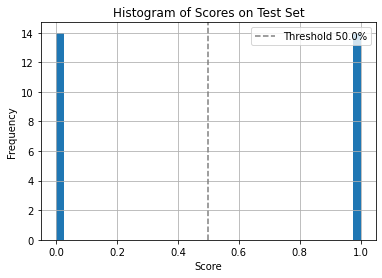

In [19]:
fig, ax = plt.subplots()
labeled_pair_ids_test["score"].hist(bins = 40, ax = ax)
ax.set_xlabel("Score")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of Scores on Test Set")
ax.axes.axvline(x = threshold, linestyle = "--", color = "grey", label = "Threshold {:.1f}%".format(threshold*100))
ax.legend()
plt.show()

In [20]:
y_true = labeled_pair_ids_test["label"]
y_pred = labeled_pair_ids_test["predicted label"]
print("Confusion Matrix\n{}".format(confusion_matrix(y_true, y_pred, labels = ["match", "distinct"])))
print("Accuracy Score {:.1f}%".format(accuracy_score(y_true, y_pred)*100))

Confusion Matrix
[[14  0]
 [ 0 14]]
Accuracy Score 100.0%
